## Sentiment Classification with BERT-based model

In [ ]:
%%capture
!pip install transformers tokenizers pytorch-lightning
!git clone https://github.com/davidtvs/pytorch-lr-finder.git && cd pytorch-lr-finder && python setup.py install

In [ ]:
import torch
from torch import nn
from typing import List
import torch.nn.functional as F
from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import logging
import os
from functools import lru_cache
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from argparse import Namespace
from sklearn.metrics import classification_report
torch.__version__

'1.4.0'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')

In [ ]:
model = AutoModelWithLMHead.from_pretrained("distilroberta-base")
base_model = model.base_model

In [ ]:
text = "Elvis is the king of rock!"
enc = tokenizer.encode_plus(text)
enc.keys()

dict_keys(['input_ids', 'attention_mask'])

We are only using `input_ids` and `attention_mask`

We need to also unsqueeze to simulate batch processing

Using DistilBertForSequenceClassification: https://huggingface.co/transformers/model_doc/distilbert.html#distilbertforsequenceclassification

In [ ]:
out = base_model(torch.tensor(enc["input_ids"]).unsqueeze(0), torch.tensor(enc["attention_mask"]).unsqueeze(0))
out[0].shape

torch.Size([1, 9, 768])

In [ ]:
out[0][:,0,:].shape

torch.Size([1, 768])

batch_size, number of tokens in input text (lenght of tokenized text), model's output hidden size

In [ ]:
t = "Elvis is the king of rock"
enc = tokenizer.encode_plus(t)
token_representations = base_model(torch.tensor(enc["input_ids"]).unsqueeze(0))[0][0]
print(enc["input_ids"])
print(tokenizer.decode(enc["input_ids"]))
print(f"Length: {len(enc['input_ids'])}")
print(token_representations.shape)

[0, 20131, 16, 5, 8453, 9, 3152, 2]
<s> Elvis is the king of rock</s>
Length: 8
torch.Size([8, 768])


## Building Custom Classification head on top of LM base model

Use Mish activiation function as in the one proposed in the original tutorial

In [ ]:
# from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))
  
class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

The model

In [ ]:
class EmoModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        
        # here I use only representation of <s> token, but you can easily use more tokens,
        # maybe do some pooling / RNNs... go crazy here!

        # use the [CLS] representation
 
        return self.classifier(hidden_states[0][:, 0, :])

### Pretest the model with dummy text

In [ ]:
classifier = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, 3)
X = torch.tensor(enc["input_ids"]).unsqueeze(0).to('cpu')
attn = torch.tensor(enc["attention_mask"]).unsqueeze(0).to('cpu')
classifier((X, attn))

tensor([[ 0.0517, -0.0110, -0.0932]], grad_fn=<AddmmBackward>)

## Prepare your dataset for fine-tuning

In [ ]:
!mkdir -p tokenizer

In [ ]:
tokenizer.save_pretrained("tokenizer")

('tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/special_tokens_map.json',
 'tokenizer/added_tokens.json')

In [ ]:
!ls tokenizer

merges.txt  special_tokens_map.json  tokenizer_config.json  vocab.json


Implement CollateFN using fast tokenizers

In [ ]:
class TokenizersCollateFn:
    def __init__(self, max_tokens=512):
        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(max_length=max_tokens, pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels

## Getting the Data In

In [ ]:
## export the datasets as txt files
path = "drive/My Drive/DAIR RESOURCES/ODSC 2020/data/"

## emotion labels
label2int = {
  "negative": 0,
  "positive": 1
}

classes = ["negative", "positive"]

In [ ]:
data = pd.read_csv(path+"imdb.csv")

In [ ]:
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


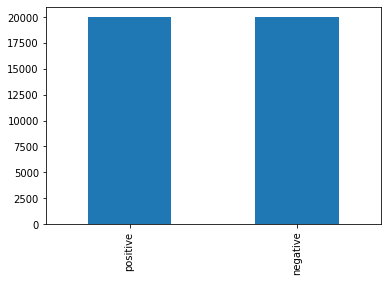

In [ ]:
data = data.sample(n=40000);

data.sentiment.value_counts().plot.bar()

In [ ]:
data.count()

review       40000
sentiment    40000
dtype: int64

Data has been preprocessed already, using technique from this paper: https://www.aclweb.org/anthology/D18-1404/

In [ ]:
data.head()

,review,sentiment
29948,I was really looking forward too seeing this m...,positive
8679,The BBC'S Blue Planet is simply jaw-dropping. ...,positive
5087,Claudine is a movie that is representation of ...,positive
5829,"""North & South"" the television mini-series is ...",positive
34528,"There are many, many older movies that deserve...",positive


In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
data.head()

,review,sentiment
0,I was really looking forward too seeing this m...,positive
1,The BBC'S Blue Planet is simply jaw-dropping. ...,positive
2,Claudine is a movie that is representation of ...,positive
3,"""North & South"" the television mini-series is ...",positive
4,"There are many, many older movies that deserve...",positive


In [ ]:
data.sentiment.unique()

array(['positive', 'negative'], dtype=object)

## Split the data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Creating training and validation sets using an 80-20 split
input_train, input_val, target_train, target_val = train_test_split(data.review.to_numpy(), 
                                                                    data.sentiment.to_numpy(), 
                                                                    test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.5)

In [ ]:
input_train

array(['"Dressed to Kill" has been more or less forgotten in critical circles in the past 20 years, but it is a true American classic, a film which is much more than just a glossy thriller.<br /><br />I sincerely hope the DVD release will give more people the chance to hear about it and see it.',
       "Certainly one of the dozen or so worst movies ever released in any form, featuring a bizarrely abominable performance by Rain Joan of Arc Phoenix (River's sister, inevitably), as Bonanza Jellybean plus inconceivably awful voiceover narration by Tom Robbins, the author of the novel, which had/retains its peculiar sweet/loopy charms.",
       'Its about time that Gunga Din is released on DVD. I cannot accurately say how many times I have watched this fine film but, I never tire of it. The lead actors worked so well together. Victor Mclaglen (Sgt McChesney), Cary Grant (Sgt Cutter) and Douglas Fairbanks Jr (Sgt Ballentine) are an unbeatable team.<br /><br />I just cannot get over their ex

In [ ]:
target_train

array(['positive', 'negative', 'positive', ..., 'positive', 'negative',
       'positive'], dtype=object)

In [ ]:
import numpy as np
## create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})
val_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})
test_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})

final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

In [ ]:
train_path = path+"train.txt"
test_path = path+"test.txt"
val_path = path+"val.txt"

train_dataset.to_csv(train_path, sep=";",header=False, index=False)
val_dataset.to_csv(test_path, sep=";",header=False, index=False)
test_dataset.to_csv(val_path, sep=";",header=False, index=False)

Create the Dataset object leveraging the CollateFN

In [ ]:
class EmoDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "class"
        self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column],
                               engine="python")

    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

    def __len__(self):
        return self.data.shape[0]

Sanity check

In [ ]:
ds = EmoDataset(train_path)
ds[19]

("I liked this movie,,cute and funny.I found this film to be a good family film.the dirtiest part of this movie was when it made references to the New York Yankees. You have to be in Red Sox nation to understand that NY Yankees is a dirty word.Sorry to say that to the Yankee's fans.I recommend this picture for the entire family.Of course with your typical love/comedy movie,,there's a long moment in the movie,,with i'm in love and what do I do,,but the movie makes up for that with all the slapstick moments.The movie show's some moments of how the Red Sox nation( in Fenway Park)how the fans felt about 86 years of the Sox always screwed up at the end of the season and how the love of the Sox and the love with another human go hand to hand.",
 1)

Training with PyTorchLightning

In [ ]:
class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, len(classes))
        self.loss = nn.CrossEntropyLoss()
        self.hparams = hparams

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr)
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

## Finding Learning Rate for the Model

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


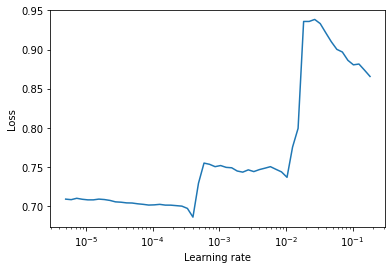

In [ ]:
lr=0.1
from torch_lr_finder import LRFinder
hparams_tmp = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=32,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1,
)
module = TrainingModule(hparams_tmp)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(module.parameters(), lr=5e-7)
lr_finder = LRFinder(module, optimizer, criterion, device="cuda")
lr_finder.range_test(module.train_dataloader(), end_lr=100, num_iter=100, accumulation_steps=hparams_tmp.accumulate_grad_batches)
lr_finder.plot()
lr_finder.reset()

In [ ]:
lr = 1e-4
lr

0.0001

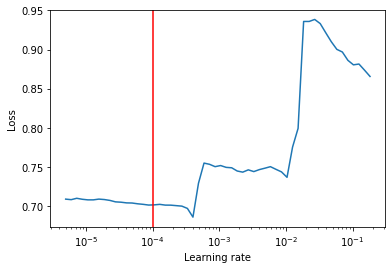

In [ ]:
lr_finder.plot(show_lr=lr)

## Training the Emotion Classifier

In [ ]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=32,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1
)
module = TrainingModule(hparams)

In [ ]:
import gc; gc.collect()
torch.cuda.empty_cache()

In [ ]:
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, progress_bar_refresh_rate=10,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

1

In [ ]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=len(classes)))


________________________________________________________________________________
              precision    recall  f1-score   support

    negative       0.95      0.93      0.94      2003
    positive       0.93      0.95      0.94      1997

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000

